# Домашняя работа №1
### Практическая Часть 
### Выполнил: Михайлов М.К.

====================================================================================================================================================================================================================================================================================================================================================

#### Условие:
В двухканальную СМО поступают заявки с интенсивностью 2 заявки в час. Поток обслуживания имеет интенсивность 4 заявки в час. Потоки поступления заявок и обслуживания - простейшие. Ожидать обслуживания в системе могут не более двух заявок. Определите показатели работы СМО.


===================================================================================================================================================================================

#### Сначала проведем одну симуляцию, чтобы оценить нужные нам показатели СМО. Затем повторим симуляции многократно, для оценки сходимости.
Опишем, как будут вычисляться величины
##### **Вероятность отказа:**
- Делим число отклоненных заявок на общее число заявок в системе

#####  **Относительная пропускная способность**:
- Делим число обслуженных заявок на общее число заявок в системе

#####  **Абсолютная пропускная способность**:
- Делим число обслуженных заявок на число часов работы

#####  **Среднее число занятых каналов**:
- Найдем число занятых каналов в каждый момент поступления новой заявки и усредним

#####  **Среднее время ожидания в очереди**:
- Сложим все временные интервалы, в течение которых какая-либо заявка находилась в очереди, и разделим на количество заявок

#####  **Среднее число заявок в системе**:
- Разобьем интервал наблюдения, например, на участки по 14 минут. Получится K участков. На каждом участке, сколько заявок в этот момент находится в системе. Затем сумму K слагаемых усреднить.

#####  **Среднее время пребывания заявки в СМО**:
- Сложим время ожидания в очереди и время обслуживания одной заявки (15 минут)

In [1]:
import numpy as np
import simpy
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import random
from termcolor import cprint

In [2]:
num_channels = 2 # Число каналов
time_to_serve_one = 15 # Время обслуживания одной заявки
time_period = 30 # Интервал между заявками
simulation_time = 4000
queue = 2 # Максимальная очередь
initial_amount = 3 # Число заявок в начальный момент времени

# для расчета вероятности отказа
declined_apps = 0 # Отклоненные заявки
apps_in_total = 0 # всего поступивших заявок

# для расчета относительной пропускной способности
apps_served = 0 # Обслуженные заявки

# для расчета абсолютной пропускной способности
working_hours = simulation_time / 60  # Общее число часов работы

# для расчета среднего числа занятых каналов
previous_time = 0
channel_count = []

# для расчета среднего числа заявок в очереди
time_one_in_queue = 0
time_two_in_queue = 0

# для расчета среднего времени нахождения в очереди
apps_in_queue = {} 

# для расчета среднего числа заявок в системе
apps_in_intervals = [set() for i in range(len(np.arange(0, simulation_time, 13)))] # Машины, которые находились в обслуживании в течение интервала времени
intervals = np.arange(0, simulation_time, 13) # Разбивка на интервалы для среднего числа заявок



class Apps(object):
    def __init__(self, env, num_channels, time_to_serve_one, queue):
        self.env = env
        self.channel = simpy.Resource(env, num_channels)
        self.serving_time = time_to_serve_one
        self.queue = queue

    def serving(self, application):
        yield self.env.timeout(random.expovariate(1 / self.serving_time))
        cprint(f"Заявка {application} обслуживается", color='yellow')
        

def application_process(env, number, app):
    global declined_apps, apps_in_total, apps_served, time_one_occupied, time_two_occupied, previous_time, time_one_in_queue, time_two_in_queue
    global apps_in_queue
    apps_in_total += 1
    cprint(f'Заявка {number} поступила на обслуживание {round(env.now, 2)}', color='cyan')
    
    # случай забивки =) очереди
    if len(app.channel.queue) == app.queue:
        declined_apps += 1
        cprint('Заявке %s отказан в обслуживании из-за повышенной очереди %.2f.' % (number, env.now), color='red')
        return
    
    # обработка заявок
    with app.channel.request() as request:
        cprint('Заявка %s встала в очередь в %.2f.' % (number, env.now), color="magenta")
        
        apps_in_queue[int(number)] = env.now
        if len(app.channel.queue) == 1:
            time_one_in_queue += env.now - previous_time
        if len(app.channel.queue) == 2:
            time_two_in_queue += env.now - previous_time
            
        previous_time = env.now
        yield request

        cprint('Заявка %s начала обслуживаться в %.2f.' % (number, env.now))
        
        # Определение какому интервалу времени принадлежит рассматриваемая заявка
        for i in range(len(intervals) - 1):
            if previous_time < intervals[i + 1] and previous_time > intervals[i]:
                apps_in_intervals[i].add(int(number))

        apps_served += 1
        if int(number) in apps_in_queue:
            apps_in_queue[int(number)] = env.now - apps_in_queue[int(number)]
        yield env.process(app.serving(number))
        cprint('Заявка %s обслужилась в %.2f.' % (number, env.now), color='green')
              
            
def setup(env, num_channels, serving_time, time_period, queue):
    app = Apps(env, num_channels, serving_time, queue)
    global channel_count
    # отправим начальное количество заявок на обслуживание
    for i in range(initial_amount):
        env.process(application_process(env, '%d' % i, app))
        
    while True:
        channel_count.append(app.channel.count)
        yield env.timeout(random.expovariate(1 / time_period))
        i += 1
        env.process(application_process(env, '%d' % i, app))
        
        
env = simpy.Environment()
env.process(setup(env, num_channels, time_to_serve_one, time_period, queue))
env.run(until=simulation_time)

Заявка 0 поступила на обслуживание 0
Заявка 0 встала в очередь в 0.00.
Заявка 1 поступила на обслуживание 0
Заявка 1 встала в очередь в 0.00.
Заявка 2 поступила на обслуживание 0
Заявка 2 встала в очередь в 0.00.
Заявка 0 начала обслуживаться в 0.00.
Заявка 1 начала обслуживаться в 0.00.
Заявка 1 обслуживается
Заявка 1 обслужилась в 4.00.
Заявка 2 начала обслуживаться в 4.00.
Заявка 2 обслуживается
Заявка 2 обслужилась в 11.39.
Заявка 3 поступила на обслуживание 20.32
Заявка 3 встала в очередь в 20.32.
Заявка 3 начала обслуживаться в 20.32.
Заявка 0 обслуживается
Заявка 0 обслужилась в 26.05.
Заявка 3 обслуживается
Заявка 3 обслужилась в 28.37.
Заявка 4 поступила на обслуживание 46.17
Заявка 4 встала в очередь в 46.17.
Заявка 4 начала обслуживаться в 46.17.
Заявка 5 поступила на обслуживание 49.92
Заявка 5 встала в очередь в 49.92.
Заявка 5 начала обслуживаться в 49.92.
Заявка 5 обслуживается
Заявка 5 обслужилась в 52.95.
Заявка 4 обслуживается
Заявка 4 обслужилась в 67.42.
Заявка 6 по

In [3]:
print(f"Вероятность отклонить заявку: {declined_apps / apps_in_total}")

Вероятность отклонить заявку: 0.012121212121212121


In [4]:
print(f"Относительная пропускная способность: {apps_served / apps_in_total}")

Относительная пропускная способность: 0.9878787878787879


In [5]:
print(f"Абсолютная пропускная способность: {apps_served / working_hours}")

Абсолютная пропускная способность: 2.445


In [6]:
print(f"Среднее число занятых каналов: {np.mean(channel_count)}")

Среднее число занятых каналов: 0.5766871165644172


In [7]:
print('Среднее число заявок, находящихся в очереди: ', (1 * time_one_in_queue / simulation_time + 2 * time_two_in_queue / simulation_time))

Среднее число заявок, находящихся в очереди:  0.04818746444781914


In [8]:
# Среднее время ожидания в очереди
print('Среднее время ожидания в очереди: ', sum(apps_in_queue.values()) / apps_in_total / 60)

Среднее время ожидания в очереди:  0.019615341856263332


In [9]:
# Среднее время пребывания заявки в СМО
T = sum(apps_in_queue.values()) / apps_in_total
T_sis = T + time_to_serve_one
print('Среднее время пребывания заявки в СМО: ', T_sis / 60)

Среднее время пребывания заявки в СМО:  0.26961534185626335


In [10]:
# Среднее число заявок в системе
L_sis = sum([len(apps_in_intervals[i]) for i in range(len(apps_in_intervals))]) / (len(apps_in_intervals))
print('Среднее число заявок в системе: ', L_sis)

Среднее число заявок в системе:  0.5194805194805194


In [11]:
iterations = 100 # Число итераций
P_dec, Q, A, k_occ, L_q, T_q, L_sys, T_sys = [], [], [], [], [], [], [], []

class Apps(object):
    def __init__(self, env, num_channels, time_to_serve_one, queue):
        self.env = env
        self.channel = simpy.Resource(env, num_channels)
        self.serving_time = time_to_serve_one
        self.queue = queue

    def serving(self, application):
        yield self.env.timeout(random.expovariate(1 / self.serving_time))
        #cprint(f"Заявка {application} обслуживается", color='yellow')
        

def application_process(env, number, app):
    global declined_apps, apps_in_total, apps_served, time_one_occupied, time_two_occupied, previous_time, time_one_in_queue, time_two_in_queue
    global apps_in_queue
    # Определение какому интервалу времени принадлежит рассматриваемая машина
    for i in range(len(intervals) - 1):
        if env.now < intervals[i + 1] and env.now > intervals[i]:
            apps_in_intervals[i].add(int(number))
    apps_in_total += 1
    
    # случай забивки =) очереди
    if len(app.channel.queue) == app.queue:
        declined_apps += 1
        return
    
    # обработка заявок
    with app.channel.request() as request:
        # Определение какому интервалу времени принадлежит рассматриваемая машина
        for i in range(len(intervals)-1):
            if env.now < intervals[i + 1] and env.now > intervals[i]:
                apps_in_intervals[i].add(int(number))
        
        apps_in_queue[int(number)] = env.now
        if len(app.channel.queue) == 1:
            time_one_in_queue += env.now - previous_time
        if len(app.channel.queue) == 2:
            time_two_in_queue += env.now - previous_time
            
        previous_time = env.now
        yield request

        # Определение какому интервалу времени принадлежит рассматриваемая машина
        for i in range(len(intervals)-1):
            if env.now < intervals[i + 1] and env.now > intervals[i]:
                apps_in_intervals[i].add(int(number))

        apps_served += 1
        if int(number) in apps_in_queue:
            apps_in_queue[int(number)] = env.now - apps_in_queue[int(number)]
        yield env.process(app.serving(number))
        #cprint('Заявка %s обслужилась в %.2f.' % (number, env.now), color='green')
        # Определение какому интервалу времени принадлежит рассматриваемая машина
        for i in range(len(intervals)-1):
            if env.now < intervals[i + 1] and env.now > intervals[i]:
                apps_in_intervals[i].add(int(number))
                
def setup(env, num_channels, serving_time, time_period, queue):
    app = Apps(env, num_channels, serving_time, queue)
    global channel_count
    # отправим начальное количество заявок на обслуживание
    for i in range(start_amount):
        env.process(application_process(env, '%d' % i, app))
        
    while True:
        channel_count.append(app.channel.count)
        yield env.timeout(random.expovariate(1/time_period))
        i += 1
        env.process(application_process(env, '%d' % i, app))
        
for i in tqdm(range(iterations)):
    
    num_channels = 2 # Число каналов
    time_to_serve_one = 15 # Время обслуживания одной заявки
    time_period = 30 # Интервал между заявками
    simulation_time = 4000
    queue = 2 # Максимальная очередь
    start_amount = 3 # Число заявок в начальный момент времени

    # для расчета вероятности отказа
    declined_apps = 0 # Отклоненные заявки
    apps_in_total = 0 # всего поступивших заявок

    # для расчета относительной пропускной способности
    apps_served = 0 # Обслуженные заявки

    # для расчета абсолютной пропускной способности
    working_hours = simulation_time / 60  # Общее число часов работы

    # для расчета среднего числа занятых каналов
    previous_time = 0
    channel_count = []

    # для расчета среднего числа заявок в очереди
    time_one_in_queue = 0
    time_two_in_queue = 0

    # для расчета среднего времени нахождения в очереди
    apps_in_query = {} # Словарь для расчета времени нахождения каждой заявки в очереди

    # для расчета среднего числа заявок в системе
    apps_in_intervals = [set() for i in range(len(np.arange(0, simulation_time, 13)))] # Машины, которые находились в обслуживании в течение интервала времени
    intervals = np.arange(0, simulation_time, 13) # Разбивка на интервалы для среднего числа заявок

    env = simpy.Environment()
    env.process(setup(env, num_channels, time_to_serve_one, time_period, queue))
    env.run(until=simulation_time)
    
    # Вероятность образования очереди
    P_dec.append(declined_apps / apps_in_total)
    
    # Относительная пропускная способность
    Q.append(apps_served/apps_in_total)
    
    # Абсолютная пропускная способность
    A.append(apps_served/working_hours)
    
    # Среднее число занятых каналов
    k_occ.append(np.mean(channel_count))
    
    # Среднее число заявок, находящихся в очереди
    L_q.append(1 * time_one_in_queue / simulation_time + 2 * time_two_in_queue / simulation_time)
    
    # Среднее время ожидания в очереди
    T = sum(apps_in_queue.values()) / apps_in_total / 60
    T_q.append(T / 60)
    
    # Среднее число заявок в системе
    L_sys.append(sum([len(apps_in_intervals[i]) for i in range(len(apps_in_intervals))]) / (len(apps_in_intervals)))
    
    # Среднее время пребывания заявки в СМО
    T_sys.append((T + time_to_serve_one) / 60)

100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


In [12]:
# Вероятность образования очереди
print('Вероятность образования очереди: ', np.mean(P_dec))

# Относительная пропускная способность
print('Относительная пропускная способность: ', np.mean(Q))

# Абсолютная пропускная способность
print('Абсолютная пропускная способность: ', np.mean(A))

# Среднее число занятых бригад
print('Среднее число занятых бригад: ', np.mean(k_occ))

# Среднее число заявок, находящихся в очереди
print('Среднее число заявок, находящихся в очереди: ', np.mean(L_q))

# Среднее время ожидания в очереди
print('Среднее время ожидания в очереди: ', np.mean(T_q))

# Среднее число заявок в системе
print('Среднее число заявок в системе: ', np.mean(L_sys))

# Среднее время пребывания заявки в СМО
print('Среднее время пребывания заявки в СМО: ', np.mean(T_sys))

Вероятность образования очереди:  0.003605448942039017
Относительная пропускная способность:  0.996259526508043
Абсолютная пропускная способность:  2.03985
Среднее число занятых бригад:  0.49922046057016095
Среднее число заявок, находящихся в очереди:  0.03216999454945658
Среднее время ожидания в очереди:  0.0017884022698279015
Среднее число заявок в системе:  0.7519155844155846
Среднее время пребывания заявки в СМО:  0.2517884022698279


### Теперь введем ошибку, как относительную разность теоретического значения метрики и полученного путем многократных симуляций.

In [13]:
iterations = 1000 # Число итераций
P_dec, Q, A, k_occ, L_q, T_q, L_sys, T_sys = [], [], [], [], [], [], [], []
# для отрисовки ошибки
Errors = []
eps = 0.4

P_dec_th = 0.005
Q_th     = 0.995
A_th     = 1.99
k_occ_th = 0.5
L_q_th   = 0.028
T_q_th   = 0.014
L_sys_th = 0.528
T_sys_th = 0.264


for i in tqdm(range(iterations)):
    
    num_channels = 2 # Число каналов
    time_to_serve_one = 15 # Время обслуживания одной заявки
    time_period = 30 # Интервал между заявками
    simulation_time = 4000
    queue = 2 # Максимальная очередь
    start_amount = 3 # Число заявок в начальный момент времени

    # для расчета вероятности отказа
    declined_apps = 0 # Отклоненные заявки
    apps_in_total = 0 # Всего поступивших заявок

    # для расчета относительной пропускной способности
    apps_served = 0 # Обслуженные заявки

    # для расчета абсолютной пропускной способности
    working_hours = simulation_time / 60  # Общее число часов работы

    # для расчета среднего числа занятых каналов
    previous_time = 0
    channel_count = []

    # для расчета среднего числа заявок в очереди
    time_one_in_queue = 0
    time_two_in_queue = 0

    # для расчета среднего времени нахождения в очереди
    apps_in_query = {} # Словарь для расчета времени нахождения каждой заявки в очереди

    # для расчета среднего числа заявок в системе
    apps_in_intervals = [set() for i in range(len(np.arange(0, simulation_time, 13)))] 
    intervals = np.arange(0, simulation_time, 13)

    env = simpy.Environment()
    env.process(setup(env, num_channels, time_to_serve_one, time_period, queue))
    env.run(until=simulation_time)
    
    # Вероятность образования очереди
    P_dec.append(declined_apps / apps_in_total)
    
    # Относительная пропускная способность
    Q.append(apps_served / apps_in_total)
    
    # Абсолютная пропускная способность
    A.append(apps_served / working_hours)
    
    # Среднее число занятых бригад
    k_occ.append(np.mean(channel_count))
    
    # Среднее число заявок, находящихся в очереди
    L_q.append(1 * time_one_in_queue / simulation_time + 2 * time_two_in_queue / simulation_time)
    
    # Среднее время ожидания в очереди
    T = sum(apps_in_queue.values()) / apps_in_total
    T_q.append(T / 60)
    
    # Среднее число заявок в системе
    L_sys.append(sum([len(apps_in_intervals[i]) for i in range(len(apps_in_intervals))]) / (len(apps_in_intervals)))
    
    # Среднее время пребывания заявки в СМО
    T_sys.append((T + time_to_serve_one) / 60)
    # относительные ошибки
    P_e     = np.abs(P_dec_th - np.mean(P_dec)) / P_dec_th
    Q_e     = np.abs(Q_th     - np.mean(Q))     / Q_th     
    A_e     = np.abs(A_th     - np.mean(A))     / A_th     
    k_e     = np.abs(k_occ_th - np.mean(k_occ)) / k_occ_th 
    L_q_e   = np.abs(L_q_th   - np.mean(L_q))   / L_q_th   
    T_q_e   = np.abs(T_q_th   - np.mean(T_q))   / T_q_th   
    L_sys_e = np.abs(L_sys_th - np.mean(L_sys)) / L_sys_th 
    T_sys_e = np.abs(T_sys_th - np.mean(T_sys)) / T_sys_th
    
    Errors.append(P_e + Q_e + A_e + k_e + L_q_e + T_q_e + L_sys_e + T_sys_e)
    condition = P_e < eps and Q_e < eps and A_e < eps and k_e < eps and L_q_e < eps and T_q_e < eps and L_sys_e < eps and T_sys_e < eps
    if i > 25 and condition:
        print('Достигли сходимости на', i, 'итерации')
        break

  3%|▎         | 26/1000 [00:16<10:35,  1.53it/s]

Достигли сходимости на 26 итерации


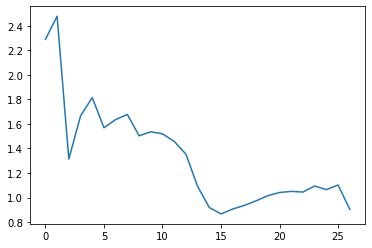

In [14]:
plt.plot(Errors);

In [16]:
df = pd.DataFrame({
    'Theory' : [P_dec_th, Q_th, A_th, k_occ_th, L_q_th, T_q_th, L_sys_th, T_sys_th],
    "Simulation mean" : [np.mean(P_dec), np.mean(Q), np.mean(A), np.mean(k_occ), np.mean(L_q), np.mean(T_q), np.mean(L_sys), np.mean(T_sys)],
    "Simulation sigma" : [np.var(P_dec, ddof=1), np.var(Q, ddof=1), np.var(A, ddof=1), np.var(k_occ, ddof=1), np.var(L_q, ddof=1), np.var(T_q, ddof=1), np.var(L_sys, ddof=1), np.var(T_sys, ddof=1)]
    
}, index =["Вероятность отказа", "Относительная пропускная способность", "Абсолютная пропускная способность", "Среднее число занятых каналов", "Средняя длина очереди", "Среднее время ожидания в очереди", "Среднее количество заявок в СМО", "Среднее время провождения в СМО"])
df

,Theory,Simulation mean,Simulation sigma
Вероятность отказа,0.005,0.003125,0.000037
Относительная пропускная способность,0.995,0.996875,0.000037
Абсолютная пропускная способность,1.990,2.057778,0.015283
Среднее число занятых каналов,0.500,0.497186,0.004832
Средняя длина очереди,0.028,0.027303,0.000144
Среднее время ожидания в очереди,0.014,0.014283,0.000041
Среднее количество заявок в СМО,0.528,0.760823,0.002905
Среднее время провождения в СМО,0.264,0.264283,0.000041


## Вывод:
- Оценки величин через симуляции сходятся с аналитическими результатами по порядку величин
- Сильнее всего разходятся среднее время ожидания в очереди и среднее количество заявок в СМО. Это можно объяснить тем, что шаг разбиения на временные интервалы подобран неудачно. И подсчет среднего времени ожидания в очереди некорректен. 
- Для оценки скорости сходимости был выбран критерий: $\varepsilon$. В этом случае сходимость наступает, когда относительная ошибка всех метрик меньше $\varepsilon$